## DS3000 Final Project: News Recommender

### Team 58

- Wesley Chung (chung.wes@northeastern.edu)
- Alex Naryshkin (naryshkin.a@northeastern.edu)
- Felix Yang (yang.fel@northeastern.edu)
- Yee Hang Fung (fung.ye@northeastern.edu)

## Executive Summary

We built a KMeans Clustering machine learning model which clustered New York Times articles by similarity of article content. Article content was acquired using the New York Times API as well as the Newspaper3k package. To compare articles from each other, we used CountVectorizer and TF-IDFVectorizer to vectorize the string of article contents, then reducing the vector dimensions to make comparisons between articles for clustering. Overall, the clusters created by the model appear to recommend similar articles, as seen in the keywords which represent each cluster being generally similar in terms of topic.

#### Table of contents:
1. [Introduction](#cell1)
2. [Data Description](#cell2)
    - [API Calls](#cell2a)
    - [Cleaning Data](#cell2b)
    - [Grab Text/Lemmatizing/Removing Stopwords](#cell2c)
3. [Method](#cell3)
    - [KMeans Clustering](#cell3)
    - [Vectorize Text Data](#cell3b)
    - [Reduce Vector Dimension](#cell3c)
4. [Results](#cell4)
5. [Discussion](#cell5)

## Introduction

<a id="cell1"></a>
The [increasing political polarization](https://www.pewresearch.org/politics/2014/06/12/political-polarization-in-the-american-public/) in the United States is associated with numerous negative consequences, including government inaction and worsening mental and physical health among Americans. Social media has become notorious for widening divides in our society as [research](https://www.cambridge.org/core/journals/episteme/article/abs/echo-chambers-and-epistemic-bubbles/5D4AC3A808C538E17C50A7C09EC706F0) and [whistleblowers](https://www.cbsnews.com/news/facebook-whistleblower-frances-haugen-60-minutes-polarizing-divisive-content/) have described how algorithms recommending content on these platforms push users toward increasingly polarizing content that makes them angry. While technology has contributed to political polarization, we believe it can also be used as a solution. **To provide users with an alternative to the current frustrating environment, we have developed a recommendation system that provides users with news they would enjoy based on similar articles they liked in the past**.

## Data Description

<a id="cell2"></a>

In [ ]:
# install necessary libraries
!pip install newspaper3k
!pip install -U textblob

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
Requirement already up-to-date: textblob in /shared-libs/python3.7/py/lib/python3.7/site-packages (0.17.1)
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# import necessary libraries
import pandas as pd
import requests
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import json
from bs4 import BeautifulSoup
import newspaper
from newspaper import Article
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# download nltk packages if necessary
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
df_data = pd.read_csv('nyt_articles(section).csv')
df_data.head()

,section,title,abstract,url,byline,published_date,des_facet,authors,plain_text,text,polarity
0,dining,They Fled Afghanistan for America. Now They Fe...,"In Virginia, Maryland and Washington, D.C., es...",https://www.nytimes.com/2022/04/18/dining/afgh...,By Brett Anderson,2022-04-18T16:06:12-04:00,"['Restaurants', 'Afghan-Americans', 'Afghanist...",['Brett Anderson'],"richmond, va. — hamidullah noori was 8 years o...",richmond va hamidullah noori 8 year old father...,0.078333
1,dining,"To Tip, or Not to Tip?",Automated payment and the spread of tipping to...,https://www.nytimes.com/2022/04/19/dining/tipp...,By Christina Morales,2022-04-19T05:00:17-04:00,"['Tips and Tipping', 'Quarantine (Life and Cul...",['Christina Morales'],"last year, anna johnson found herself using an...",last year anna johnson found using electronic ...,0.069150
2,dining,Rolo’s Looks Like a Corner Tavern in Queens. I...,Three chefs in the savory kitchen and a pastry...,https://www.nytimes.com/2022/04/19/dining/rolo...,By Pete Wells,2022-04-19T11:55:19-04:00,"['Restaurants', 'Chefs']",['Pete Wells'],this is not a complaint anyone will make about...,complaint anyone make rolos cooking tends towa...,0.109202
3,dining,"KYU, an Eclectic Miami Transplant, Opens in NoHo",Innovative mussels in the meatpacking district...,https://www.nytimes.com/2022/04/19/dining/nyc-...,By Florence Fabricant,2022-04-19T12:27:31-04:00,"['Restaurants', 'Cooking and Cookbooks']",['Florence Fabricant'],"headliner\n\nkyu\n\nreversing a trend, a miami...",headliner kyu reversing trend miami restaurant...,0.077460
4,dining,"In West Oakland, Barbecue Is Back — With a Sid...","With Horn Barbecue and Kowbird fried chicken, ...",https://www.nytimes.com/2022/04/18/dining/kowb...,By Tejal Rao,2022-04-18T14:20:32-04:00,"['Restaurants', 'Barbecue', 'Black People', 'M...",['Tejal Rao'],"oakland, calif. — if you’re in this jumbled, c...",oakland calif youre jumbled chatty line envelo...,0.093155


We build the above dataframe by querying the New York Times Top Stories API and using various built-in python libraries to produce useful, reliable information on the contents of each article. 

<a id="cell2a"></a>
1. We first call the New York Times Top Stories API to obtain information about articles. The API stores a plethora of data, but attributes relevant to this project are:
- section (to give us a sense of topic)
- title (to give us a sense of topic)
- abstract (brief description of article)
- url (to get the article content)
- byline (authors of article)
- published_date (when the article was written)
- dec_facet (descriptive facets of article)

In [ ]:
import os

api_key = os.environ["API"]

# build the url for the request with the api key (not submitted)
nyt_url = f'https://api.nytimes.com/svc/topstories/v2/food.json?api-key={api_key}'

# get the api response and load as a dict
nyt_response = requests.get(nyt_url).text
nyt_dict = json.loads(nyt_response)

# store articles in the response in a dataframe
nyt_df = pd.DataFrame(nyt_dict['results'])

nyt_df.head()

,section,subsection,title,abstract,url,uri,byline,item_type,updated_date,created_date,published_date,material_type_facet,kicker,des_facet,org_facet,per_facet,geo_facet,multimedia,short_url
0,dining,,Banh Mi in a Drive-Through? Vietnamese Restaur...,"From a former KFC to a 1950s-style drive-in, o...",https://www.nytimes.com/2022/04/26/dining/viet...,nyt://article/bbe48983-65a6-54d6-b8e2-11a4f6b1...,By Priya Krishna,Article,2022-04-26T17:16:06-04:00,2022-04-26T05:00:26-04:00,2022-04-26T05:00:26-04:00,,,"[Vietnamese Food (Cuisine), Vietnamese-America...","[Hughie's (Houston, Tex, Restaurant)]",[],[North America],[{'url': 'https://static01.nyt.com/images/2022...,https://nyti.ms/3MufLLo
1,dining,,Foraging for Ramps With the King of Appalachia...,"Every spring, Allan Benton heads to the woods ...",https://www.nytimes.com/2022/04/25/dining/alla...,nyt://article/32e87141-3857-5083-b442-5b1c0e8d...,By Brett Anderson,Article,2022-04-25T15:25:41-04:00,2022-04-25T12:17:50-04:00,2022-04-25T12:17:50-04:00,,,"[Ham, Flowers and Plants, Content Type: Person...",[Benton's Smoky Mountain Country Hams],"[Benton, Allan (Food Executive)]",[Appalachian Region],[{'url': 'https://static01.nyt.com/images/2022...,https://nyti.ms/3Li47CX
2,dining,,An Especially Good Tuna Salad Sandwich Starts ...,It’s hard to say exactly when tuna and potato ...,https://www.nytimes.com/2022/04/25/dining/tuna...,nyt://article/cc1000e1-65f0-513d-b775-d17ab29a...,By J. Kenji López-Alt,Article,2022-04-25T15:48:43-04:00,2022-04-25T13:21:29-04:00,2022-04-25T13:21:29-04:00,,,"[Cooking and Cookbooks, Sandwiches, Tuna, Pota...",[],[],[],[{'url': 'https://static01.nyt.com/images/2022...,https://nyti.ms/3xRfn5j
3,dining,,"Sweet and Squishy as Ever, the Gummy Universe ...","On its 100th anniversary, the colorful candy h...",https://www.nytimes.com/2022/04/25/dining/hari...,nyt://article/f33fbfd9-76c9-510a-872a-5f87c140...,By Mahira Rivers,Article,2022-04-26T08:22:15-04:00,2022-04-25T15:56:02-04:00,2022-04-25T15:56:02-04:00,,,[Candy],[Haribo],"[Riegel, Hans (1923-2013)]",[],[{'url': 'https://static01.nyt.com/images/2022...,https://nyti.ms/36OrlSk
4,dining,,The Pavlova Begs for Improvisation,It’s easy to riff on this meringue-based shows...,https://www.nytimes.com/2022/04/22/dining/pavl...,nyt://article/f63b36b4-b3fb-5fbc-a038-8eb54448...,By Eric Kim,Article,2022-04-25T13:28:03-04:00,2022-04-22T18:00:52-04:00,2022-04-22T18:00:52-04:00,,,"[Cookies, Cooking and Cookbooks, Eggs, Dancing...",[],"[Pavlova, Anna]",[],[{'url': 'https://static01.nyt.com/images/2022...,https://nyti.ms/3LbUcPh


<a id="cell2b"></a>
2. Next, we remove empty entries, unecessary columns, and clean the author column

In [ ]:
# get only columns of data relevant to our pipeline
columns = ['section', 'title', 'abstract', 'url', 'byline', 'published_date', 'des_facet']
nyt_df = nyt_df.loc[:, columns]

# delete any rows that contain empty values for author and abstract
nyt_df['byline'].replace('', np.nan, inplace=True)
nyt_df['abstract'].replace('', np.nan, inplace=True)
nyt_df.dropna(axis=0, how='any', inplace=True)

In [ ]:
def clean_author(author):
    ''' cleans the authors from NYT byline column API call
    
    Args:
        author (str): author string (might have multiple)
    
    Returns:
        new_author (list): list of strings of authors
    '''
    new_author = author.replace('By ', '')
    new_author = new_author.replace(' and ', ',')
    new_author = new_author.replace(', ', ',')
    new_author = new_author.split(',')
    return new_author

nyt_df['authors'] = nyt_df['byline'].map(clean_author)

<a id="cell2c"></a>
3. The written contents of the article are very important for this project because this is our main source for comparison between articles. To obtain the text of articles for each article returned by our query to the NYT API we call the following function:

In [ ]:
# import more necessary libraries
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
def get_article(url):
    ''' gets the text from an article
    
    Args:
        url (str): the article url
    
    Returns:
        article.text (str): the article's plain text
    '''
    article = Article(url)
    article.download()
    article.parse()
    article.nlp()
    return article.text.lower()

nyt_df['plain_text'] = nyt_df['url'].map(get_article)

The above method will add a column plain_text to our dataframe that contains the word-for-word text of the article. However, since this project is concerned with simialirty between text it is very important we "normalize" the contents of each article. This is important for semantic simialirity comparisons. We achieve this by calling function `clean_text()` that:

- removes all "stopwords" (and, her, have, is, while, a, etc) that can make two different strings/articles appear similiar when in reality their substance ("more important" words) are quite different
  - via function `remove_stopwords()`
- lemmatizing the substance of the string/article to "normalize" the tense/plurality of all words so that the same words of different tense, for example can still be recognized as the same
  - via function `lemmatize_cont()`

For example,

"Alice went to the cookie store and bought a lot of cookies that she could have gotten earlier"

becomes...

"Alice go cookie store buy lot cookie get early"

In [ ]:
def remove_stopwords(content):
    """ removes common english "stopwords" from string

    Args:
        content (str) : the string to remove from

    Returns:
        filtered (list) : list of strings without any stopwords
    """
    stop_words = set(stopwords.words('english'))

    word_tokens = word_tokenize(content)
    
    filtered = [w for w in word_tokens if not w.lower() in stop_words]

    return filtered

In [ ]:
def lemmatize_cont(list_content):
    """ lemmatizes the contents of a string

    Args:
        list_content (list) : list of string

    Returns:
        cleaned_content (str) : 
    """
    lemmatizer = WordNetLemmatizer()
    cleaned_content = ''
    for string in list_content:
        cleaned_content += lemmatizer.lemmatize(string) + ' '
    return cleaned_content

In [ ]:
def clean_text(text):
    """ cleans the article's text, eliminating stopwords and lemmatizing

      Args:
          text (str) : the article's text

      Returns:
          content (str) : the article's clean text
    """
    # cleans content
    text = re.sub(r'[^\w\s]','',text)
    no_stopwords = remove_stopwords(text)
    cleaned_content = lemmatize_cont(no_stopwords)

    return cleaned_content

In [ ]:
nyt_df['text'] = nyt_df['plain_text'].map(clean_text)

...to obtain the final dataframe.

In [ ]:
nyt_df

,section,title,abstract,url,byline,published_date,des_facet,authors,plain_text,text
0,dining,Banh Mi in a Drive-Through? Vietnamese Restaur...,"From a former KFC to a 1950s-style drive-in, o...",https://www.nytimes.com/2022/04/26/dining/viet...,By Priya Krishna,2022-04-26T05:00:26-04:00,"[Vietnamese Food (Cuisine), Vietnamese-America...",[Priya Krishna],"she wants mi-sant, which opened in 2018 and ha...",want misant opened 2018 another location area ...
1,dining,Foraging for Ramps With the King of Appalachia...,"Every spring, Allan Benton heads to the woods ...",https://www.nytimes.com/2022/04/25/dining/alla...,By Brett Anderson,2022-04-25T12:17:50-04:00,"[Ham, Flowers and Plants, Content Type: Person...",[Brett Anderson],"madisonville, tenn. — allan benton started sel...",madisonville tenn allan benton started selling...
2,dining,An Especially Good Tuna Salad Sandwich Starts ...,It’s hard to say exactly when tuna and potato ...,https://www.nytimes.com/2022/04/25/dining/tuna...,By J. Kenji López-Alt,2022-04-25T13:21:29-04:00,"[Cooking and Cookbooks, Sandwiches, Tuna, Pota...",[J. Kenji López-Alt],who introduced you to your first tuna and pota...,introduced first tuna potato chip sandwich lun...
3,dining,"Sweet and Squishy as Ever, the Gummy Universe ...","On its 100th anniversary, the colorful candy h...",https://www.nytimes.com/2022/04/25/dining/hari...,By Mahira Rivers,2022-04-25T15:56:02-04:00,[Candy],[Mahira Rivers],"like many german companies, haribo has come un...",like many german company haribo come scrutiny ...
4,dining,The Pavlova Begs for Improvisation,It’s easy to riff on this meringue-based shows...,https://www.nytimes.com/2022/04/22/dining/pavl...,By Eric Kim,2022-04-22T18:00:52-04:00,"[Cookies, Cooking and Cookbooks, Eggs, Dancing...",[Eric Kim],"if you’ve ever attempted a pavlova at home, th...",youve ever attempted pavlova home know joy mak...
5,dining,A Streamlined Spring Risotto in Shades of Pink...,"A whole bunch of chard adds color and texture,...",https://www.nytimes.com/2022/04/22/dining/spri...,By Melissa Clark,2022-04-22T09:18:05-04:00,"[Cooking and Cookbooks, Risotto, Chard (Vegeta...",[Melissa Clark],the day i found out that i didn’t have to stan...,day found didnt stand risotto pot stirring con...
6,dining,"With Corsican Reds, a Case Study of Identity",What is the source of the distinctiveness in t...,https://www.nytimes.com/2022/04/21/dining/drin...,By Eric Asimov,2022-04-21T10:23:03-04:00,"[Wines, Grapes]",[Eric Asimov],each of these wines is made with corsica’s two...,wine made corsica two leading red grape niellu...
7,dining,"Kono, Yakitori From an Expert, Opens in Manhat...",Mike Solomonov and Steve Cook’s latest arrives...,https://www.nytimes.com/2022/04/26/dining/nyc-...,By Florence Fabricant,2022-04-26T15:32:56-04:00,[Restaurants],[Florence Fabricant],"headliner\n\nkono\n\nomakase, a type of japane...",headliner kono omakase type japanese meal leaf...
8,dining,They Fled Afghanistan for America. Now They Fe...,"In Virginia, Maryland and Washington, D.C., es...",https://www.nytimes.com/2022/04/18/dining/afgh...,By Brett Anderson,2022-04-18T16:06:12-04:00,"[Restaurants, Afghan-Americans, Afghanistan Wa...",[Brett Anderson],"richmond, va. — hamidullah noori was 8 years o...",richmond va hamidullah noori 8 year old father...
9,dining,"To Tip, or Not to Tip?",Automated payment and the spread of tipping to...,https://www.nytimes.com/2022/04/19/dining/tipp...,By Christina Morales,2022-04-19T05:00:17-04:00,"[Tips and Tipping, Quarantine (Life and Cultur...",[Christina Morales],"last year, anna johnson found herself using an...",last year anna johnson found using electronic ...


## Visualizations

#### 1. Sentiment polarity of each section

We are going to investigate sentiment polarity of each section. It is measured by sentiment polarity score that ranges from -1 and 1, where 1 means positive sentiment and -1 means negative sentiment. In order to do this, we use textblob's sentiment polarity function.

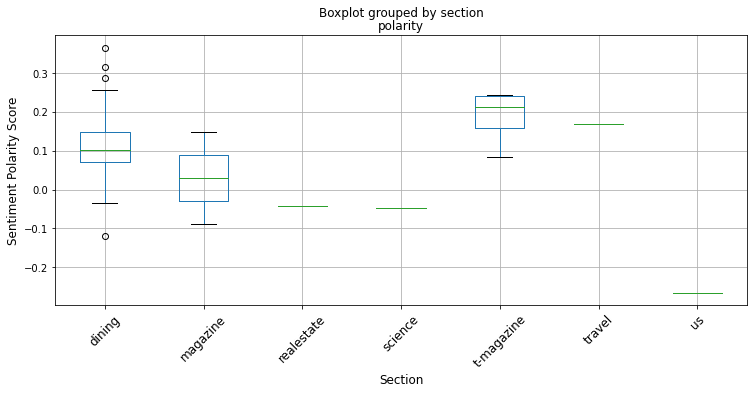

In [ ]:
# calculate semtiment polarity score of each abstract
nyt_df['polarity'] = nyt_df['text'].map(lambda text: TextBlob(text).sentiment.polarity)

# plot the boxplot
nyt_df.boxplot(by = 'section',column = ['polarity'])

plt.xlabel('Section',fontsize = 12)
plt.ylabel('Sentiment Polarity Score',fontsize = 12)
plt.xticks(rotation = 45,fontsize = 12)

plt.gcf().set_size_inches(12, 5)

plt.show()

From the above boxplot, longer boxes indicate higher in sentiment polarity. 

We can observe that sentiment of new articles from 'Movies' and 'Opinion' section are comparatively polarized. In overall, median of the sentiment polarity score of major boxes are above 0, indicating they tends to have positive sentiment.

There is a limitation in this graph: some 'boxes' (e.g. books, dining and dining, etc. ) only show the the median. It is due to too few news articles under these section in our dataset, so we are not able to observe the sentiment polarity of them.


#### 2. Top n-grams in all articles

We would like to investigate the distribution of top n-grams in all articles. N-grams are used to describe the number of words used as observation points, e.g., unigram means singly-worded, 2-gram means two-worded phrase, and 3-gram means 3-worded phrase. In order to do this, we use scikit-learn's CountVectorizer function.

In [ ]:
def get_top_n_ngram(corpus, n=None,gram = 2):
    ''' get the top 2-grams from given corpus
    
    Args:
        corpus (pd.Series): text that we want to get top 2-grams from 
        n (int): number of top 2-grams we want to get
        gram: number of word in phrases 

    Return:
        words_freq (sparse matrix): top 2-grams with their frequency
    '''
    # create a vector of 2-grams from the targeted text
    vec = CountVectorizer(ngram_range=(gram, gram), stop_words='english').fit(corpus)
    
    # transform the vector into a corpus
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    
    # count the frquency of each 2-grams, store into a list
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # sort the list by frquency in descending order
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

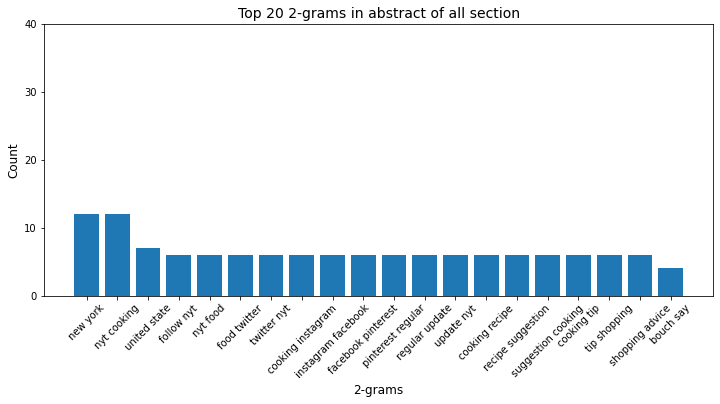

In [ ]:
# get the most common words
common_words = get_top_n_ngram(nyt_df['text'], 20)

# create dataframe
nyt_count = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

# plot settings
plt.bar(nyt_count['ReviewText'],nyt_count['count'])
plt.xlabel('2-grams',fontsize = 12)
plt.ylabel('Count',fontsize = 12)
plt.xticks(rotation = 45,fontsize = 10)
plt.yticks(np.arange(0,50,10))
plt.title('Top 20 2-grams in abstract of all section',fontsize = 14)
plt.gcf().set_size_inches(12,5)
plt.show()

Here, we can see the most commonly used phrases within the set of articles. The most commonly used two word phrases often relate to names of people, either the author themselves or people referenced within the article, or place names, such as 'new york' or 'united states'.  

## Method

### Vectorize text data

<a id="cell3b"></a>
To put our text data in the model, we need to convert them into a vector. We convert our text in 'text' column into 2 types of vector: a matrix of token counts by CountVectorizer, and a matrix of Term Frequency-Inverse Document Frequency (TF-IDF) features by TfidfVectorizer. We set max_features = 100 in both vectorizer objects, because we only want the top-100 most frequent words to build the vector.

CountVectorizer creates a matrix in which each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix. The value of each cell is the count of the word in that particular text sample.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# extract text data from dataframe and convert it into a list
text = list(nyt_df['text'])

# initialize counter vectorizer object
count_vectorizer = CountVectorizer(stop_words = 'english', max_features = 100)

# transform each article into a vector
counter_X = count_vectorizer.fit_transform(text)

counter_X.shape

(38, 100)

In [ ]:
# print each unique word represented by each column
count_vectorizer.get_feature_names()

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['according',
 'advice',
 'american',
 'bar',
 'bottle',
 'bouch',
 'brooklyn',
 'candy',
 'center',
 'cheese',
 'chef',
 'chicken',
 'chip',
 'come',
 'company',
 'cook',
 'cooking',
 'day',
 'dinner',
 'dish',
 'dont',
 'eat',
 'escovitch',
 'facebook',
 'fish',
 'follow',
 'food',
 'francine',
 'french',
 'good',
 'grape',
 'heart',
 'home',
 'hot',
 'hotel',
 'ice',
 'ill',
 'im',
 'instagram',
 'island',
 'italian',
 'kitchen',
 'leave',
 'like',
 'make',
 'meal',
 'month',
 'morel',
 'mr',
 'music',
 'new',
 'nyt',
 'oil',
 'okra',
 'open',
 'oyster',
 'pan',
 'pandemic',
 'pavlova',
 'people',
 'percent',
 'pinterest',
 'potato',
 'really',
 'recipe',
 'red',
 'regular',
 'restaurant',
 'said',
 'sandwich',
 'sauce',
 'say',
 'served',
 'shopping',
 'small',
 'soft',
 'space',
 'state',
 'street',
 'suggestion',
 'sweet',
 'thing',
 'think',
 'time',
 'tip',
 'try',
 'turn',
 'twitter',
 'united',
 'university',
 'used',
 'vegetable',
 'vinegar',
 'way',
 'wine',
 'work',
 'worl

Comparing to CountVectorizer, TF-IDF vectors consider the frequency of words across whole text sample, instead of particular text sample. Mathematically, TF is the number of times a word appears in a document divided by the total number of words in the document. And IDF = log(N/n) where N is the total number of documents and n is the number of documents a term has appeared in. TF-IDF value for a word is the product of TF and IDF.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# extract text data from dataframe and convert it into a list
text = list(nyt_df['text'])

# initialize tfidf vectorizer object
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 100)

# transform each article into a vector
tfidf_X = tfidf_vectorizer.fit_transform(text)

tfidf_X.shape

(38, 100)

In [ ]:
# check whether the 100 unique words of two vectors are identical 
count_vectorizer.get_feature_names() == tfidf_vectorizer.get_feature_names()

True

Based off of these metrics, we can take an initial look at the various similarities of the articles that we have through a heatmap by cosine similarity.

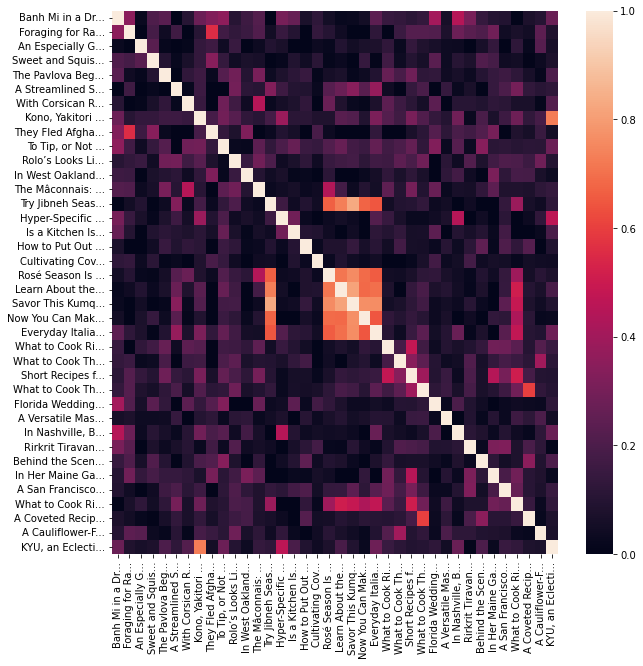

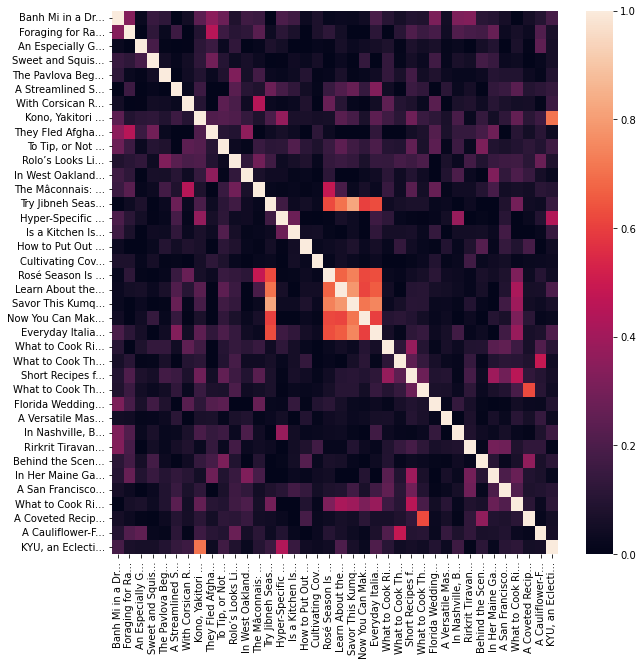

In [ ]:
from matplotlib.colors import LogNorm, Normalize
from sklearn.metrics.pairwise import cosine_similarity

def create_heatmap(arr):
    ''' creates a heatmap of the cosine similarities
    args.
        arr (numpy array): array to compute cosine similarity on
    '''
    # add titles to sides
    title_abv = [title[:15] + '...' for title in nyt_df['title']]

    # set dataframe for cosine similarities in vectors
    df = pd.DataFrame(cosine_similarity(arr), columns = title_abv)

    # plot settings
    df.index = title_abv
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(df)

# count vectorizer heatmap
arr = counter_X.toarray()
create_heatmap(arr)

# count vectorizer heatmap
arr2 = tfidf_X.toarray()
create_heatmap(arr2)

### Reduce vector dimension

<a id="cell3c"></a>
After we get two 100-column vectors, we reduce dimension of the vectors to degree 2. Our motivation of dimensionality reduction is: 
-  to remove correlation between 100 unique words in each vector
-  to see whether it improves our clustering result (shortening distance between centroids and data points)
-  to plot in 2-D graph 

We do this by Truncated Singular Value Decomposition (SVD). Contrary to Principle Content Analysis (PCA), this estimator does not center the data before computing the SVD. This means it can work with sparse matrices (like TF-IDF vector) efficiently.


In [ ]:
from sklearn.decomposition import TruncatedSVD

# initialize TruncatedSVD object
# n_component = 2: reduce the dimension of vector to degree 2
tsvd = TruncatedSVD(n_components = 2)

# reduce dimension of each vector
trunc_counter_X = tsvd.fit_transform(counter_X)
trunc_tfidf_X = tsvd.fit_transform(tfidf_X)

# print the shape of two vectors
print(trunc_counter_X.shape)
print(trunc_tfidf_X.shape)

(38, 2)
(38, 2)


### KMeans Clustering

<a id="cell3"></a>
We are doing a classification problem (identifying similar news) and we do not know how many groups will be divided. To recommend news to users, we use KMeans Clustering because it allows us to cluster the data into different groups and it is a convenient way to discover the categories of groups in the unlabeled dataset.

Before we put our data in the KMeans clustering model, we can select news from a single section. If we put news from all sections in the model, because news from same section are intuitively more similar, so the model will probably cluster the news by section, which might not be insightful. Therefore, our model aims to cluster news from same section. In this project, we choose to cluster news from 'dining' section.

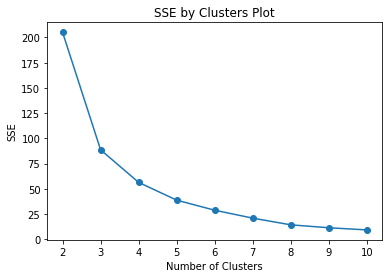

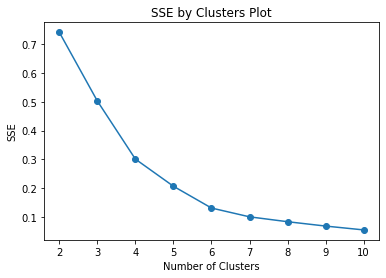

In [ ]:
from sklearn.cluster import KMeans

def find_optimal_clusters(data, max_k):
    ''' Plots the Sum of Squared Error in comparison to the
        number of clusters to look for an "elbow" point
    
    Args:
        data: Vectorized fit of our plain text through TFIDF
        max_k (int): the max k iterated from 2-max_k    
    '''
    # set iteration range
    iters = range(2, max_k+1)
    
    # get sse values
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k).fit(data).inertia_)


    # configure plot    
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Number of Clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Clusters Plot')
    
# look for number of clusters for counter vectorizer
find_optimal_clusters(trunc_counter_X, 10)

# look for number of clusters for tfidf
find_optimal_clusters(trunc_tfidf_X, 10)

We see for the Truncated CountVectorizer that there is seemingly an "elbow" at 3 clusters while for TF-IDF, we could consider 4 clusters or 6 clusters that would be good. 

## Results

Below, we will initialize the clusters and graph them based off of the two dimensions from the Truncated SVD. We can see how the articles are cluster together in such a way while being able to see their respective centers. We will also assign them to our initial articles and take a look at some keywords that connects the clusters. Firstly, we can look at the CountVectorizer.

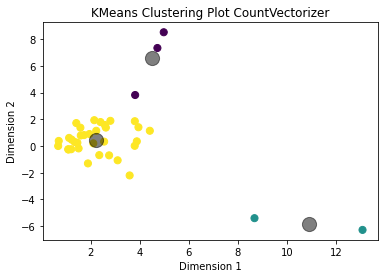

In [ ]:
# create KMeans for CountVectorizer
km = KMeans(n_clusters = 3)
km.fit(trunc_counter_X)

# store the labels and centroids
labels = km.labels_
centers = km.cluster_centers_

# plot the labels and centroids
plt.scatter(trunc_counter_X[:,0],trunc_counter_X[:,1], c = labels, s = 50, cmap = 'viridis')
plt.scatter(centers[:,0],centers[:,1], c = 'black', s = 200, alpha = 0.5)

# add title and x,y labels
plt.title('KMeans Clustering Plot CountVectorizer')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()

In [ ]:
# show the title of the article and section with their cluster
cluster_df = pd.DataFrame()
cluster_df['title'] = nyt_df['title']
cluster_df['section'] = nyt_df['section']
cluster_df['text'] = nyt_df['text']
cluster_df['cluster_cv'] = km.labels_
cluster_df

,title,section,text,cluster_cv
0,Banh Mi in a Drive-Through? Vietnamese Restaur...,dining,want misant opened 2018 another location area ...,2
1,Foraging for Ramps With the King of Appalachia...,dining,madisonville tenn allan benton started selling...,2
2,An Especially Good Tuna Salad Sandwich Starts ...,dining,introduced first tuna potato chip sandwich lun...,2
3,"Sweet and Squishy as Ever, the Gummy Universe ...",dining,like many german company haribo come scrutiny ...,2
4,The Pavlova Begs for Improvisation,dining,youve ever attempted pavlova home know joy mak...,2
5,A Streamlined Spring Risotto in Shades of Pink...,dining,day found didnt stand risotto pot stirring con...,2
6,"With Corsican Reds, a Case Study of Identity",dining,wine made corsica two leading red grape niellu...,2
7,"Kono, Yakitori From an Expert, Opens in Manhat...",dining,headliner kono omakase type japanese meal leaf...,1
8,They Fled Afghanistan for America. Now They Fe...,dining,richmond va hamidullah noori 8 year old father...,2
9,"To Tip, or Not to Tip?",dining,last year anna johnson found using electronic ...,2


In [ ]:
# grouping the articles and text by clusters
cluster_assignments_dict = {}
for i in set(km.labels_):
    #print i
    current_cluster = cluster_df[cluster_df["cluster_cv"] == i][['title','section', 'text']]
    cluster_assignments_dict[i] = current_cluster

# get keywords from each cluster
cluster_themes_dict = {}
for key in cluster_assignments_dict.keys():
    curr_text = list(cluster_assignments_dict[key]['text'])

    # initialize tfidf object
    # max_feature = 100: we choose the top 100 most frequent word to build the vector of each article
    vectorize_curr = TfidfVectorizer(stop_words = 'english', max_features = 100)

    # transform each article into a vector
    current_tfs = vectorize_curr.fit_transform(curr_text)

    # get top 10 words from articles within each cluster
    current_tf_idfs = dict(zip(vectorize_curr.get_feature_names_out(), vectorize_curr.idf_))
    tf_idfs_tuples = current_tf_idfs.items()
    cluster_themes_dict[key] = sorted(tf_idfs_tuples, key = lambda x: x[1])[:10]

for num_clust in range(3):
    print(f'Cluster {num_clust} has keywords: {[x[0] for x in cluster_themes_dict[num_clust]]}\n')

Cluster 0 has keywords: ['dont', 'allspice', 'away', 'chicken', 'come', 'cooking', 'day', 'deepfried', 'dish', 'dripping']

Cluster 1 has keywords: ['al', 'america', 'bar', 'brooklyn', 'center', 'chef', 'chile', 'cocktail', 'company', 'dish']

Cluster 2 has keywords: ['like', 'new', 'time', 'recipe', 'year', 'cooking', 'food', 'make', 'said', 'come']



In [ ]:
from collections import Counter

Counter(cluster_df['cluster_cv'])

Counter({2: 33, 1: 2, 0: 3})

Cluster 0 seems to have more terms about just cooking itself and what the recipe and food is like. Cluster 1 seems to be the most descriptive of the food, maybe pointing towards the style of American food and what makes an American chef. Cluster 2 doesn't even seem to be all that related to food. However, it seems to mostly be this specific due to placing only a few articles into clusters 0 and 1 while the rest go into cluster 2.

Next, we will repeat for TF-IDF.

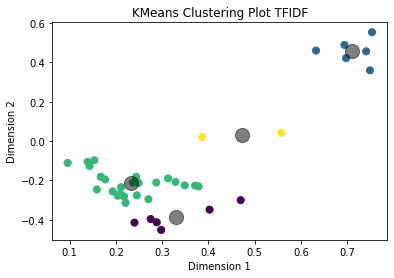

In [ ]:
# create KMeans for TF-IDF
km2 = KMeans(n_clusters = 4)
km2.fit(trunc_tfidf_X)

# store the labels and centroids
labels = km2.labels_
centers = km2.cluster_centers_

# plot the labels and centroids
plt.scatter(trunc_tfidf_X[:,0],trunc_tfidf_X[:,1], c = labels, s = 50, cmap = 'viridis')
plt.scatter(centers[:,0],centers[:,1], c = 'black', s = 200, alpha = 0.5)

# add title and x,y labels
plt.title('KMeans Clustering Plot TFIDF')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()

In [ ]:
# show the title of the article and section with their cluster
cluster_df['cluster_tfidf'] = km2.labels_
cluster_df

,title,section,text,cluster_cv,cluster_tfidf
0,Banh Mi in a Drive-Through? Vietnamese Restaur...,dining,want misant opened 2018 another location area ...,2,0
1,Foraging for Ramps With the King of Appalachia...,dining,madisonville tenn allan benton started selling...,2,0
2,An Especially Good Tuna Salad Sandwich Starts ...,dining,introduced first tuna potato chip sandwich lun...,2,2
3,"Sweet and Squishy as Ever, the Gummy Universe ...",dining,like many german company haribo come scrutiny ...,2,2
4,The Pavlova Begs for Improvisation,dining,youve ever attempted pavlova home know joy mak...,2,2
5,A Streamlined Spring Risotto in Shades of Pink...,dining,day found didnt stand risotto pot stirring con...,2,3
6,"With Corsican Reds, a Case Study of Identity",dining,wine made corsica two leading red grape niellu...,2,2
7,"Kono, Yakitori From an Expert, Opens in Manhat...",dining,headliner kono omakase type japanese meal leaf...,1,0
8,They Fled Afghanistan for America. Now They Fe...,dining,richmond va hamidullah noori 8 year old father...,2,0
9,"To Tip, or Not to Tip?",dining,last year anna johnson found using electronic ...,2,2


In [ ]:
# grouping the articles and text by clusters
cluster_assignments_dict = {}
for i in set(km2.labels_):
    #print i
    current_cluster = cluster_df[cluster_df["cluster_tfidf"] == i][['title','section', 'text']]
    cluster_assignments_dict[i] = current_cluster

# get keywords from each cluster
cluster_themes_dict = {}
for key in cluster_assignments_dict.keys():
    curr_text = list(cluster_assignments_dict[key]['text'])

    # initialize tfidf object
    # max_feature = 100: we choose the top 100 most frequent word to build the vector of each article
    vectorize_curr = TfidfVectorizer(stop_words = 'english', max_features = 100)

    # transform each article into a vector
    current_tfs = vectorize_curr.fit_transform(curr_text)

    # get top 10 words from articles within each cluster
    current_tf_idfs = dict(zip(vectorize_curr.get_feature_names_out(), vectorize_curr.idf_))
    tf_idfs_tuples = current_tf_idfs.items()
    cluster_themes_dict[key] = sorted(tf_idfs_tuples, key = lambda x: x[1])[:10]

for num_clust in range(4):
    print(f'Cluster {num_clust} has keywords: {[x[0] for x in cluster_themes_dict[num_clust]]}\n')

Cluster 0 has keywords: ['restaurant', 'year', 'day', 'feel', 'like', 'mr', 'said', 'time', '2018', 'actually']

Cluster 1 has keywords: ['advice', 'cooking', 'facebook', 'follow', 'food', 'instagram', 'nyt', 'pinterest', 'recipe', 'regular']

Cluster 2 has keywords: ['like', 'new', 'come', 'make', 'said', 'think', 'time', 'year', 'dont', 'thing']

Cluster 3 has keywords: ['cooking', '245', 'aaa', 'able', 'access', 'account', 'administration', 'allow', 'andrew', 'attention']



In [ ]:
Counter(cluster_df['cluster_tfidf'])

Counter({0: 6, 2: 24, 3: 2, 1: 6})

Above, cluster 0 has words of time on the calendar. Cluster 1 has more advice and social media terms when it comes to cooking. Cluster 2 seems to be very miscellaneous words and doesn't really distinguish itself. Cluster 3 is a bit similar and funnily includes a lot of terms starting with "a" with terms that don't really mean much in "245" and "aaa," but are still included. In regards to the count, it seems that the more articles within the cluster, the more general the terms are.

## Discussion

### Shortcomings

<a id="cell5"></a>
- It is hard to generalize and verify our data in a concrete numerical method. 
- The data we used for comparison only comprised of a few dozen articles from the New York Times, for simplicity's sake; to increase accuracy, it would likely benefit the model to expand both the number of articles included within the model with a more random sampling of articles. 
- Likewise, it would be of benefit to the model to introduce different kinds of newspapers and magazines into the model, instead of just using the New York Times. This would allow the model to recommend articles from other writers and newspapers, which would benefit the user.
- Other comparison methods might be used for different effect (e.g. different kinds of vectorization)

### Takeaways

In general, comparison via natural language processing is a difficult procedure due to a number of factors, chiefly being that language itself is incredibly complex and the same concept can be described in many different ways. As such, creating a model that is able to account for all these intricacies, and then interpreting how similar different strings are can be a challenging task. One of the difficulties is that word counts are often not entirely helpful when it came to comparing strings. With most writings, a non-stopword word might only appear once or twice, and to that end basing comparisons on the frequency of a certain word or words is not reliable as a method of comparison. This is why we chose vectorization of strings as our method of comparison, as it allowed us to compare the whole string with other vectors of strings. Regardless, there are still other considerations to be wary of within natural language processing, such as connotative language and words with multiple definitions. To this end, our process only tracks words that appear the same, rather than working at the level where humans can distinguish context and how words are being used in different scenarios. The vectorization method helps with this slightly, as it can help by maintaining phrases as units for comparison. The clustering method also did appear to somewhat group terms into semantic buckets, such as Cluster 1 being more social media focused. However, even within our clusters there are clearly some improvements to be made; for instance, Cluster 3 contained "nonsense" words such as '245' and 'aaa', which do not appear to benefit readers in understanding articles. Regardless, this clustering model serves as a good example for how we might use natural language processing and machine learning to help users make comparisons and conclusions for different sets of strings, whether it be in deciding the next article to read or for other purposes.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2c8e19e6-caf8-421e-a617-64dbe47bfa3f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>